In [29]:
import os
import glob
import pandas as pd

expected_columns = ['logtime', 'scenario_time', 'type', 'module', 'address', 'value']

result_dir = '../raw data'
result_files = glob.glob(os.path.join(result_dir, '*.csv'))

all_perf_rows = []

for file in result_files:
    with open(file, 'r') as f:
        lines = f.readlines()
        scenario_line = lines[1].strip()
        # Find the last .txt in the line and extract the scenario name
        if '.txt' in scenario_line:
            txt_part = scenario_line.split('.txt')[0]
            scenario_filename = txt_part.split('/')[-1].split('\\')[-1]
            scenario = scenario_filename
        else:
            scenario = scenario_line  # fallback
    user = os.path.basename(file).split('_')[1]
    df = pd.read_csv(file, skiprows=2)
    if len(df.columns) >= len(expected_columns):
        df.columns = expected_columns + list(df.columns[len(expected_columns):])
    else:
        missing = len(expected_columns) - len(df.columns)
        df.columns = list(df.columns) + ['unknown'] * missing
    # Only keep performance rows and exclude genericscales
    if 'type' in df.columns and 'module' in df.columns:
        perf_rows = df[(df['type'] == 'performance') & (df['module'] != 'genericscales')].copy()
    else:
        perf_rows = pd.DataFrame()
    # scenario_time is now explicitly kept
    exclude_cols = [col for col in perf_rows.columns if 'timestamp' in col.lower()] + ['logtime', 'type']
    perf_rows = perf_rows.drop(columns=exclude_cols, errors='ignore')
    perf_rows['scenario'] = scenario
    perf_rows['user'] = user
    perf_rows['task_type'] = perf_rows['module'].apply(lambda x: x.split('_')[0])
    perf_rows = perf_rows.drop(columns=['module'])
    all_perf_rows.append(perf_rows)

perf_df = pd.concat(all_perf_rows, ignore_index=True)
# scenario_task_tables now contains the grouped tables for each scenario and task_type


agg:   scenario  avg_hits  avg_misses  avg_response_time
0       no  0.669102    0.230887        3652.047619
1   visual  0.666863    0.226272        3568.008658
2    vocal  0.487351    0.263727        4186.147186
3       vv  0.613002    0.197564        3491.619048


/var/folders/ds/cyyl9tw54j12pq79761n2rt00000gn/T/ipykernel_3383/3376599227.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(scenarios)


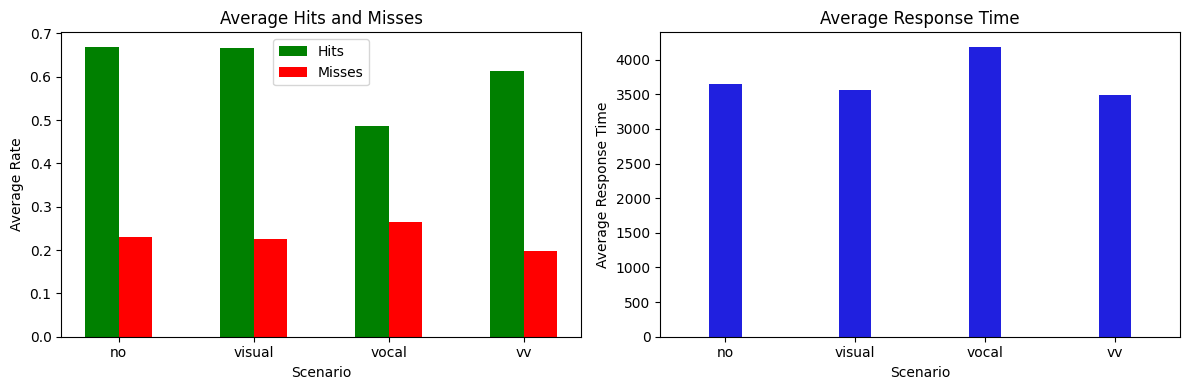

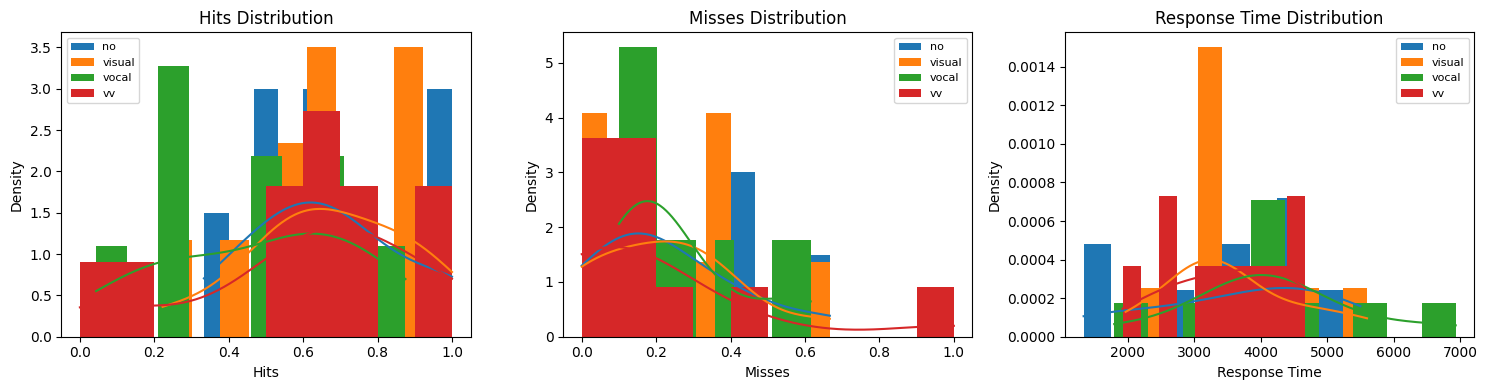

Key statistics table:
  scenario  hits_mean  hits_std  misses_mean  misses_std  response_time_mean  \
0       no   0.669102  0.216690     0.230887    0.205233         3652.047619   
1   visual   0.666863  0.222717     0.226272    0.202158         3568.008658   
2    vocal   0.487351  0.262460     0.263727    0.175710         4186.147186   
3       vv   0.613002  0.314517     0.197564    0.296857         3491.619048   

   response_time_std  
0        1380.836290  
1        1017.761066  
2        1316.114074  
3         909.740215  


In [30]:
# Aggregate sysmon HIT/MISS counts and response times per scenario and user
sysmon_df = perf_df[perf_df['task_type'] == 'sysmon'].copy()

# Map scenario codes to readable names
scenario_map = {
    '0': 'no',
    '1': 'visual',
    '2': 'vocal',
    '3': 'vv',
    'no': 'no',
    'visual': 'visual',
    'vocal': 'vocal',
    'vv': 'vv'
}

def map_scenario(s):
    s_str = str(s).lower()
    for k, v in scenario_map.items():
        if s_str == k or s_str.startswith(k):
            return v
    return s_str

sysmon_df['scenario'] = sysmon_df['scenario'].apply(map_scenario)

# Get HIT/MISS events
signal_df = sysmon_df[sysmon_df['address'] == 'signal_detection'].copy()
signal_df['is_hit'] = (signal_df['value'] == 'HIT').astype(int)
signal_df['is_miss'] = (signal_df['value'] == 'MISS').astype(int)

f6_df= sysmon_df[sysmon_df['address'] == 'name'].copy()  # Assuming 'f6' is a placeholder for some other data
f6_df['f6_value'] = (f6_df['value'] == 'F6').astype(int)  # Rename for clarity, if needed
# Get response times
response_df = sysmon_df[sysmon_df['address'] == 'response_time'].copy()
response_df['response_time'] = pd.to_numeric(response_df['value'], errors='coerce')

# Aggregate by scenario and user
user_agg = signal_df.groupby(['scenario', 'user']).agg(
    hits=('is_hit', 'mean'),
    misses=('is_miss', 'mean')
).reset_index()
user_response = response_df.groupby(['scenario', 'user'])['response_time'].mean().reset_index()
user_agg = user_agg.merge(user_response, on=['scenario', 'user'], how='left')

# Aggregate by scenario (average across users)
agg = user_agg.groupby('scenario').agg(
    avg_hits=('hits', 'mean'),
    avg_misses=('misses', 'mean'),
    avg_response_time=('response_time', 'mean')
).reset_index()
print(f'agg: {agg}')

import matplotlib.pyplot as plt
import seaborn as sns

# --- Publication-ready average plots in one figure ---
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bar_width = 0.25  # narrower bars for compactness
scenarios = agg['scenario']
index = range(len(scenarios))

# Average Hits and Misses
axs[0].bar(index, agg['avg_hits'], bar_width, label='Hits', color='green', alpha=1.0)
axs[0].bar([i + bar_width for i in index], agg['avg_misses'], bar_width, label='Misses', color='red', alpha=1.0)
axs[0].set_xlabel('Scenario')
axs[0].set_ylabel('Average Rate')
axs[0].set_title('Average Hits and Misses')
axs[0].set_xticks([i + bar_width / 2 for i in index])
axs[0].set_xticklabels(scenarios)
axs[0].legend()

# Average Response Time
sns.barplot(x='scenario', y='avg_response_time', data=agg, color='blue', ax=axs[1], width=bar_width, alpha=1.0)
axs[1].set_title('Average Response Time')
axs[1].set_xlabel('Scenario')
axs[1].set_ylabel('Average Response Time')
axs[1].set_xticklabels(scenarios)

plt.tight_layout()
plt.show()

# --- Publication-ready distribution plots in one figure ---
import itertools
unique_scenarios = list(user_agg['scenario'].unique())
color_palette = sns.color_palette('tab10', n_colors=len(unique_scenarios))
scenario_colors = dict(zip(unique_scenarios, color_palette))

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
metrics = [('hits', 'Hits'), ('misses', 'Misses'), ('response_time', 'Response Time')]
for ax, (col, label) in zip(axs, metrics):
    for scenario in unique_scenarios:
        vals = user_agg[user_agg['scenario'] == scenario][col].dropna()
        sns.histplot(vals, kde=True, label=scenario, stat='density', bins=10, ax=ax, color=scenario_colors[scenario], alpha=1.0, linewidth=0)
    ax.set_title(f'{label} Distribution')
    ax.set_xlabel(label)
    ax.set_ylabel('Density')
    ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Calculate and display key statistics table (mean and std for each scenario and metric)
stats = user_agg.groupby('scenario').agg(
    hits_mean=('hits', 'mean'), hits_std=('hits', 'std'),
    misses_mean=('misses', 'mean'), misses_std=('misses', 'std'),
    response_time_mean=('response_time', 'mean'), response_time_std=('response_time', 'std')
).reset_index()
print('Key statistics table:')
print(stats)


In [31]:
# Export the sysmon key statistics table to CSV and clipboard for publication
stats_rounded = stats.round(3)
stats_rounded.to_csv('sysmon_key_statistics.csv', index=False)
stats_rounded.to_clipboard(index=False)
print("Key statistics table (rounded to 3 decimals) exported to 'sysmon_key_statistics.csv' and copied to clipboard.")


Key statistics table (rounded to 3 decimals) exported to 'sysmon_key_statistics.csv' and copied to clipboard.


Extracted resman deviation data:


address,scenario,user,scenario_time,a_deviation,b_deviation
0,no,Alain,0.092401,0,0
1,no,Alain,2.094876,-26,-26
2,no,Alain,35.014974,-52,-52
3,no,Alain,37.017794,-78,-78
4,no,Alain,39.021586,0,-104


Average a/b response times per scenario:


address,scenario,a_response_time,b_response_time
0,no,23833.333333,37646.666667
1,visual,31000.000000,49666.666667
2,vocal,30666.666667,49181.818182
3,vv,17777.777778,35727.272727


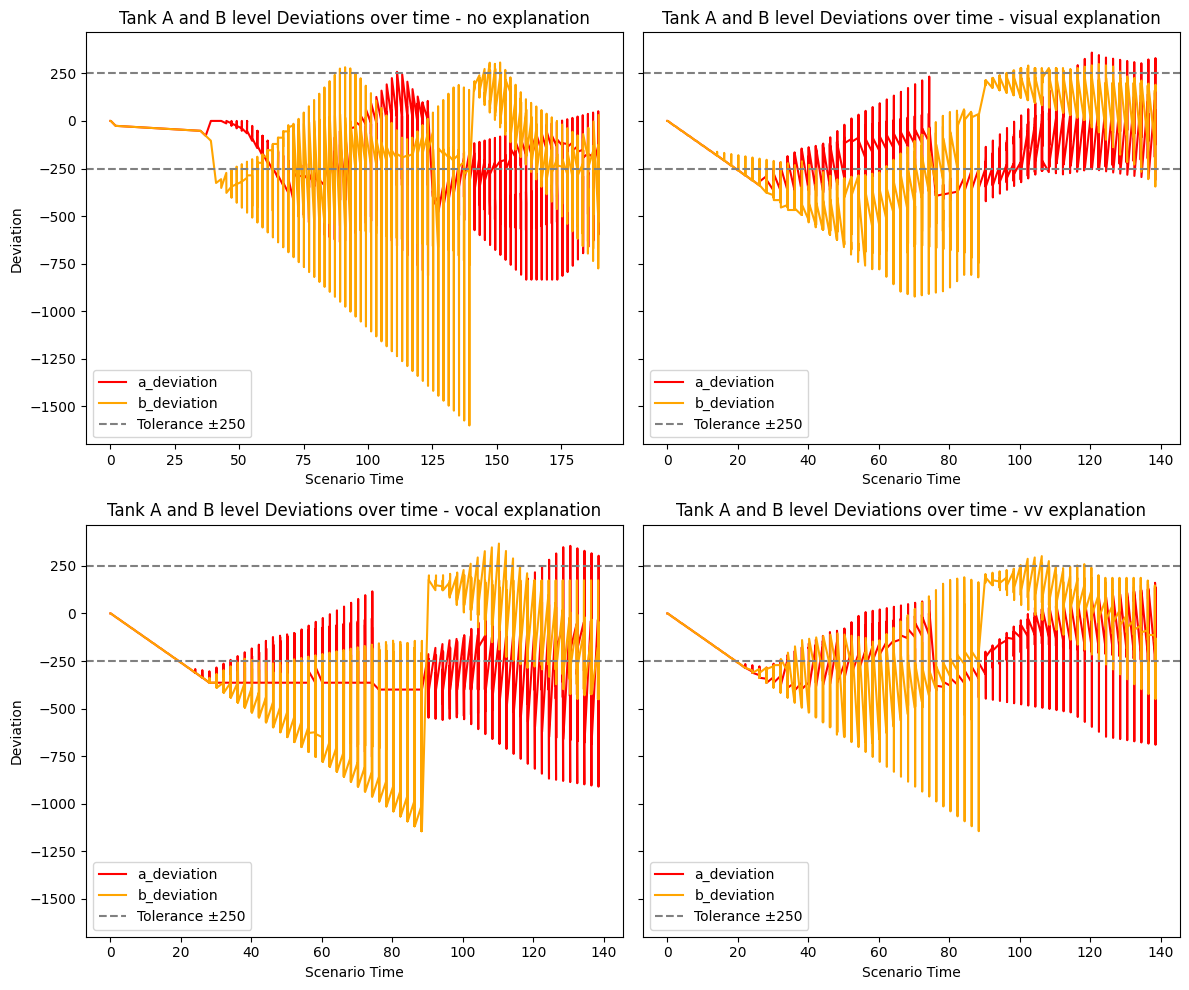

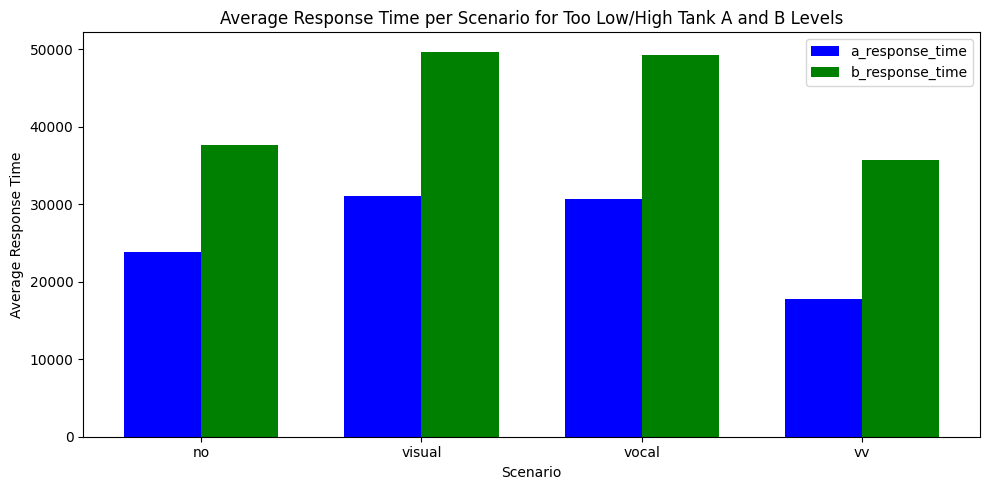

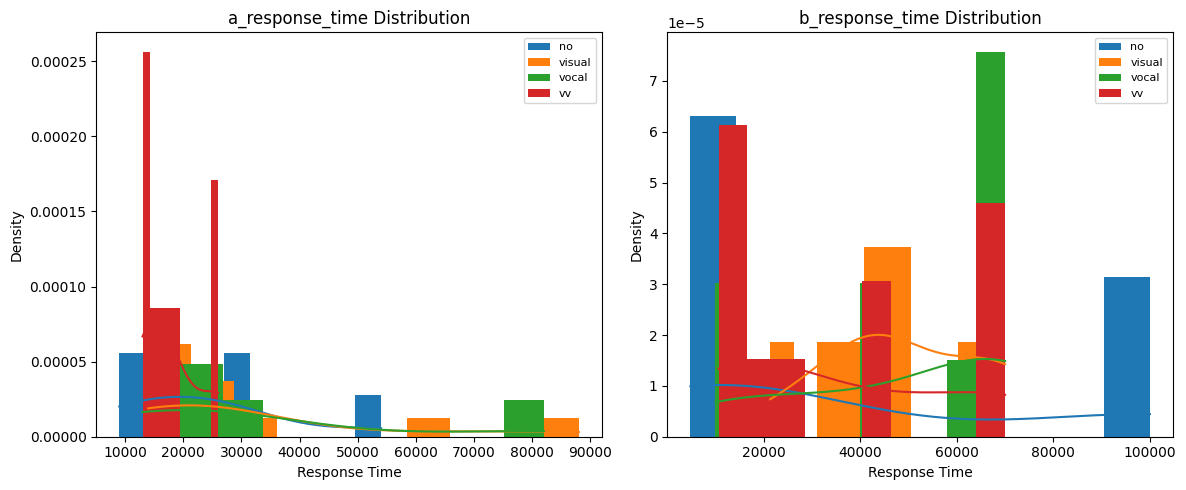

In [32]:
# Extract resman performance data including scenario_time
resman_df = perf_df[(perf_df['task_type'] == 'resman')].copy()

# Map scenario codes to readable names
scenario_map = {
    '0': 'no',
    '1': 'visual',
    '2': 'vocal',
    '3': 'vv',
    'no': 'no',
    'visual': 'visual',
    'vocal': 'vocal',
    'vv': 'vv'
}

def map_scenario(s):
    s_str = str(s).lower()
    for k, v in scenario_map.items():
        if s_str == k or s_str.startswith(k):
            return v
    return s_str

resman_df['scenario'] = resman_df['scenario'].apply(map_scenario)

# Keep scenario_time and relevant columns
target_cols = ['scenario', 'user', 'scenario_time', 'address', 'value']
resman_df = resman_df[target_cols]

# Pivot to get only deviations for a and b as columns
target_addresses = ['a_deviation', 'b_deviation']
resman_pivot = resman_df[resman_df['address'].isin(target_addresses)].copy()
resman_pivot['value'] = pd.to_numeric(resman_pivot['value'], errors='coerce')
resman_wide = resman_pivot.pivot_table(
    index=['scenario', 'user', 'scenario_time'],
    columns='address',
    values='value',
    aggfunc='first'
).reset_index()

print('Extracted resman deviation data:')
display(resman_wide.head())

# Extract a_response_time and b_response_time for resman
resman_resp = resman_df[resman_df['address'].isin(['a_response_time', 'b_response_time'])].copy()
resman_resp['value'] = pd.to_numeric(resman_resp['value'], errors='coerce')
resman_resp_wide = resman_resp.pivot_table(
    index=['scenario', 'user'],
    columns='address',
    values='value',
    aggfunc='mean'
).reset_index()

# Compute average response times per scenario
avg_resp = resman_resp_wide.groupby('scenario')[['a_response_time', 'b_response_time']].mean().reset_index()
print('Average a/b response times per scenario:')
display(avg_resp)

# --- Combined time series plot for all scenarios in 2 rows ---
import matplotlib.pyplot as plt
import seaborn as sns

tolerance_radius = 250
scenarios = list(resman_wide['scenario'].unique())
n_scenarios = len(scenarios)
ncols = (n_scenarios + 1) // 2
nrows = 2 if n_scenarios > 1 else 1
fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows), sharey=True)
axs = axs.flatten() if n_scenarios > 1 else [axs]
for ax, scenario in zip(axs, scenarios):
    scenario_df = resman_wide[resman_wide['scenario'] == scenario]
    avg_df = scenario_df.groupby('scenario_time')[['a_deviation', 'b_deviation']].mean().reset_index()
    sns.lineplot(data=avg_df, x='scenario_time', y='a_deviation', label='a_deviation', color='red', ax=ax)
    sns.lineplot(data=avg_df, x='scenario_time', y='b_deviation', label='b_deviation', color='orange', ax=ax)
    ax.axhline(tolerance_radius, color='gray', linestyle='--', label='Tolerance ±250')
    ax.axhline(-tolerance_radius, color='gray', linestyle='--')
    ax.set_title(f'Tank A and B level Deviations over time - {scenario} explanation')
    ax.set_xlabel('Scenario Time')
    ax.set_ylabel('Deviation')
    ax.legend()
# Hide any unused subplots
for i in range(len(scenarios), len(axs)):
    fig.delaxes(axs[i])
plt.tight_layout()
plt.show()

# Plot average a_response_time and b_response_time as bar chart for all scenarios
plt.figure(figsize=(10, 5))
bar_width = 0.35
index = range(len(avg_resp['scenario']))
plt.bar(index, avg_resp['a_response_time'], bar_width, label='a_response_time', color='blue')
plt.bar([i + bar_width for i in index], avg_resp['b_response_time'], bar_width, label='b_response_time', color='green')
plt.xlabel('Scenario')
plt.ylabel('Average Response Time')
plt.title('Average Response Time per Scenario for Too Low/High Tank A and B Levels')
plt.xticks([i + bar_width / 2 for i in index], avg_resp['scenario'])
plt.legend()
plt.tight_layout()
plt.show()

# --- Distribution plots for resman response times by scenario ---
unique_scenarios = list(resman_resp_wide['scenario'].unique())
color_palette = sns.color_palette('tab10', n_colors=len(unique_scenarios))
scenario_colors = dict(zip(unique_scenarios, color_palette))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, resp_col in enumerate(['a_response_time', 'b_response_time']):
    for scenario in unique_scenarios:
        vals = resman_resp_wide[resman_resp_wide['scenario'] == scenario][resp_col].dropna()
        sns.histplot(vals, kde=True, label=scenario, stat='density', bins=10, ax=axs[i], color=scenario_colors[scenario], alpha=1.0, linewidth=0)
    axs[i].set_title(f'{resp_col} Distribution')
    axs[i].set_xlabel('Response Time')
    axs[i].set_ylabel('Density')
    axs[i].legend(fontsize=8)
plt.tight_layout()
plt.show()


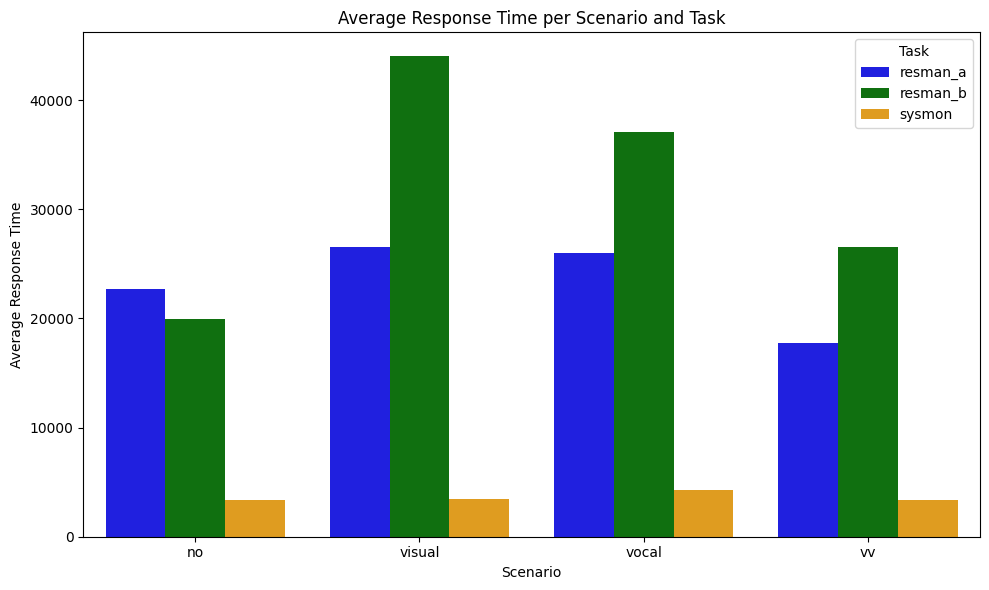

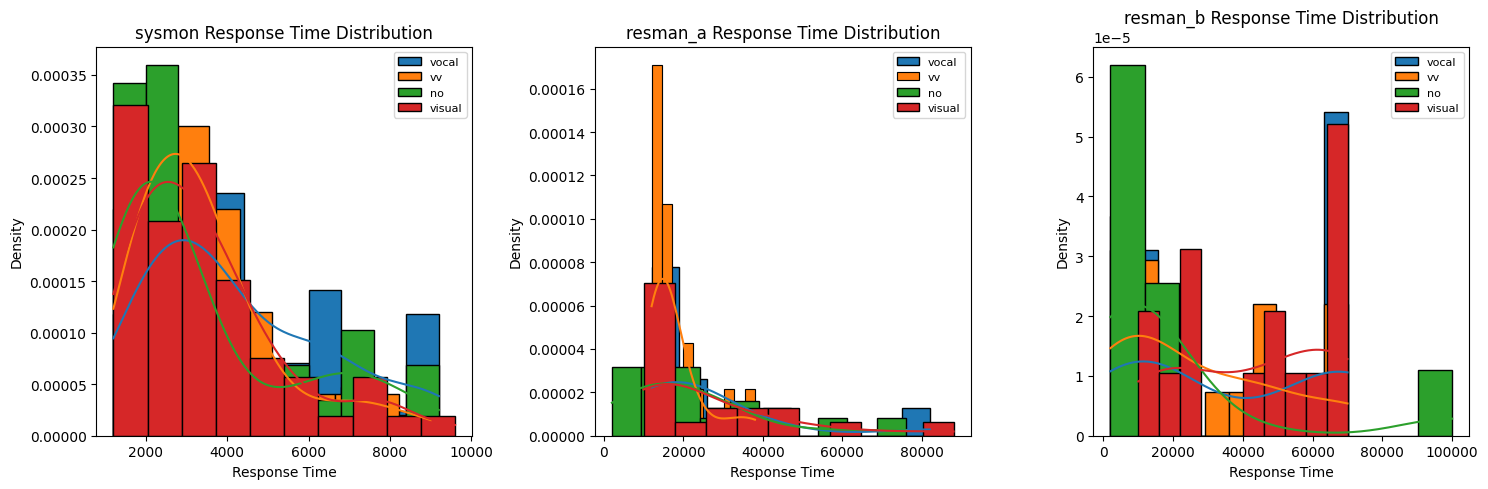

In [33]:
# --- Combine sysmon and resman response times and plot averages and distributions ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare sysmon response times
sysmon_response = sysmon_df[sysmon_df['address'] == 'response_time'][['scenario', 'user', 'value']].copy()
sysmon_response['response_time'] = pd.to_numeric(sysmon_response['value'], errors='coerce')
sysmon_response['task'] = 'sysmon'
sysmon_response = sysmon_response[['scenario', 'user', 'response_time', 'task']]

# Prepare resman response times (a and b)
resman_a = resman_df[resman_df['address'] == 'a_response_time'][['scenario', 'user', 'value']].copy()
resman_a['response_time'] = pd.to_numeric(resman_a['value'], errors='coerce')
resman_a['task'] = 'resman_a'
resman_a = resman_a[['scenario', 'user', 'response_time', 'task']]
resman_b = resman_df[resman_df['address'] == 'b_response_time'][['scenario', 'user', 'value']].copy()
resman_b['response_time'] = pd.to_numeric(resman_b['value'], errors='coerce')
resman_b['task'] = 'resman_b'
resman_b = resman_b[['scenario', 'user', 'response_time', 'task']]

# Combine all
combined = pd.concat([sysmon_response, resman_a, resman_b], ignore_index=True)

# Plot average response times per scenario and task
avg_combined = combined.groupby(['scenario', 'task'])['response_time'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='scenario', y='response_time', hue='task', data=avg_combined, palette=['blue', 'green', 'orange'])
plt.xlabel('Scenario')
plt.ylabel('Average Response Time')
plt.title('Average Response Time per Scenario and Task')
plt.legend(title='Task')
plt.tight_layout()
plt.show()

# Plot distributions of response times per task
plt.figure(figsize=(15, 5))
for i, task in enumerate(['sysmon', 'resman_a', 'resman_b']):
    plt.subplot(1, 3, i+1)
    for scenario in combined['scenario'].unique():
        vals = combined[(combined['task'] == task) & (combined['scenario'] == scenario)]['response_time'].dropna()
        sns.histplot(vals, kde=True, label=scenario, stat='density', bins=10, alpha=1.0)
    plt.title(f'{task} Response Time Distribution')
    plt.xlabel('Response Time')
    plt.ylabel('Density')
    plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

Overall System Response Time: Mean = 12257.711, Std = 18541.806


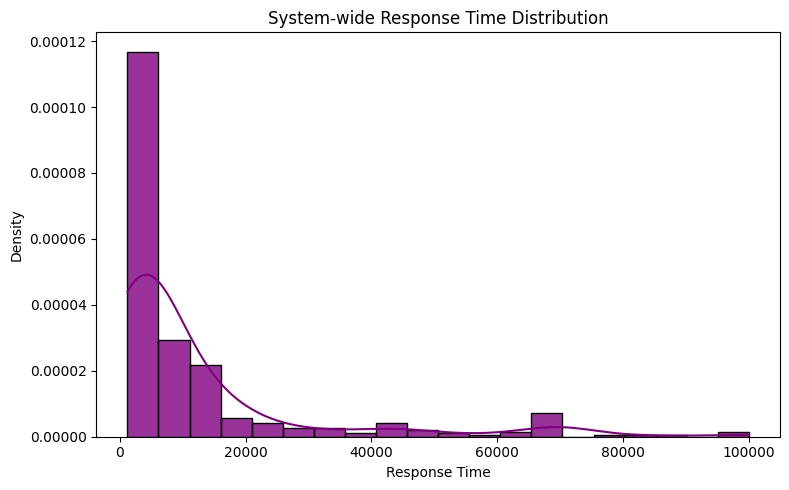

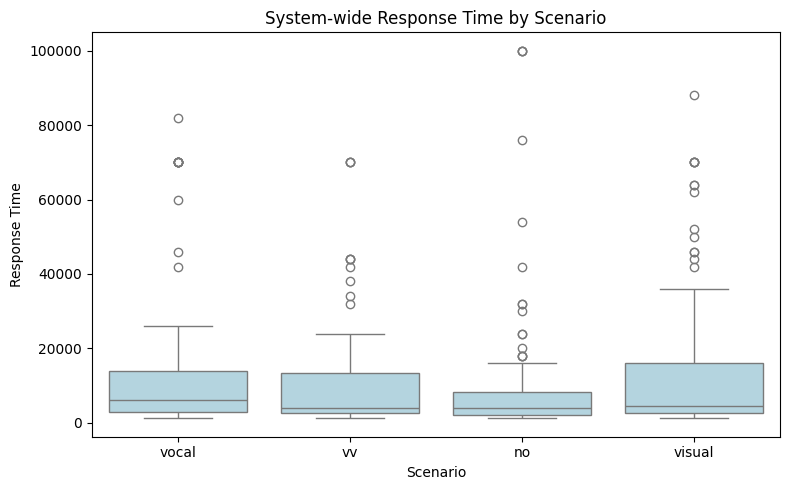

System-wide response time metrics exported to 'system_response_time_metrics.csv'.


In [34]:
# --- System-wide response time analysis: combine all tasks ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use the previously created 'combined' DataFrame (sysmon, resman_a, resman_b)
# Combine all response times for overall system metrics
system_response = combined['response_time'].dropna()

# Overall average and std
overall_mean = system_response.mean()
overall_std = system_response.std()
print(f'Overall System Response Time: Mean = {overall_mean:.3f}, Std = {overall_std:.3f}')

# Plot overall distribution
plt.figure(figsize=(8, 5))
sns.histplot(system_response, kde=True, stat='density', bins=20, color='purple', alpha=0.8)
plt.title('System-wide Response Time Distribution')
plt.xlabel('Response Time')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# Boxplot for system-wide response times by scenario
plt.figure(figsize=(8, 5))
sns.boxplot(x=combined['scenario'], y=combined['response_time'], color='lightblue')
plt.title('System-wide Response Time by Scenario')
plt.xlabel('Scenario')
plt.ylabel('Response Time')
plt.tight_layout()
plt.show()

# Export overall metrics
overall_metrics = pd.DataFrame({'mean': [overall_mean], 'std': [overall_std]})
overall_metrics.to_csv('system_response_time_metrics.csv', index=False)
print("System-wide response time metrics exported to 'system_response_time_metrics.csv'.")

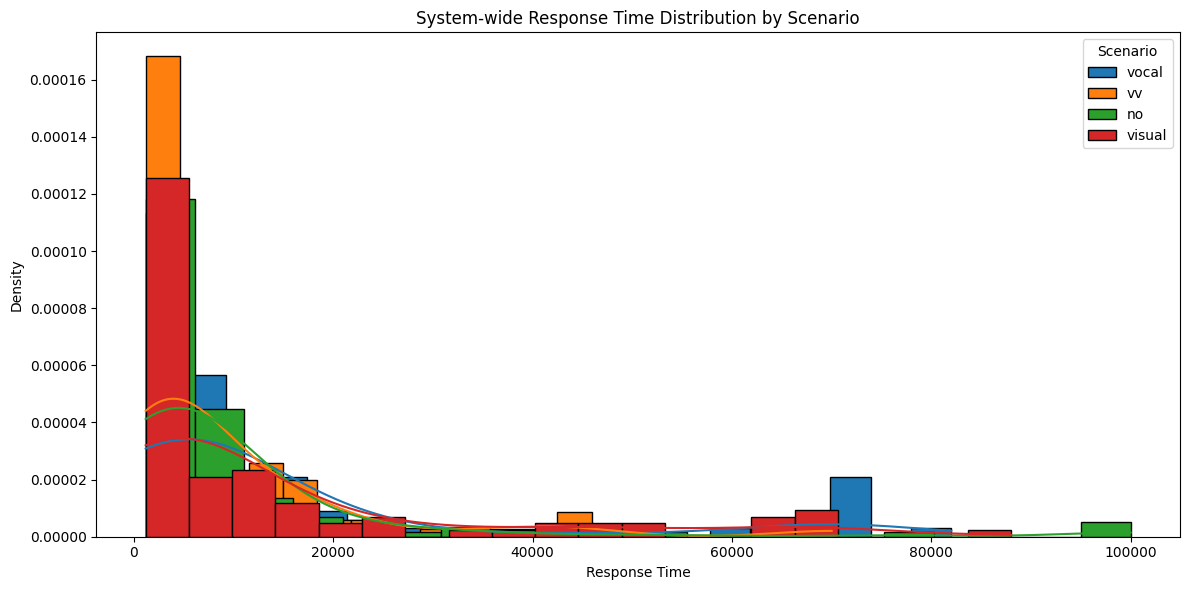

In [35]:
# --- System-wide response time distribution by scenario ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
scenarios = combined['scenario'].unique()
for scenario in scenarios:
    vals = combined[combined['scenario'] == scenario]['response_time'].dropna()
    sns.histplot(vals, kde=True, label=scenario, stat='density', bins=20, alpha=1)
plt.title('System-wide Response Time Distribution by Scenario')
plt.xlabel('Response Time')
plt.ylabel('Density')
plt.legend(title='Scenario', fontsize=10)
plt.tight_layout()
plt.show()

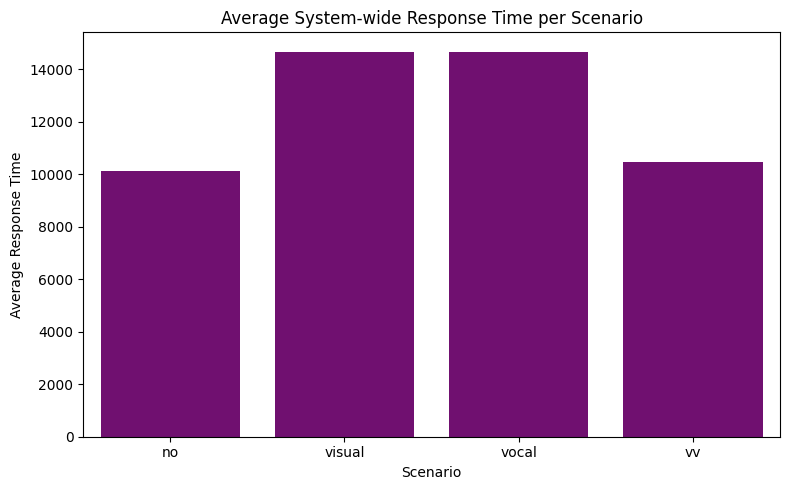

In [36]:
# --- Plot average system-wide response time per scenario ---
import matplotlib.pyplot as plt
import seaborn as sns

avg_system = combined.groupby('scenario')['response_time'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='scenario', y='response_time', data=avg_system, color='purple')
plt.title('Average System-wide Response Time per Scenario')
plt.xlabel('Scenario')
plt.ylabel('Average Response Time')
plt.tight_layout()
plt.show()

In [38]:
# --- Add rows to sysmon where address is 'name' and value is 'F6' ---
f6_rows = sysmon_df[(sysmon_df['address'] == 'name') & (sysmon_df['value'] == 'F6')].copy()
print(f'Number of rows where address is "name" and value is "F6": {len(f6_rows)}')
print(f6_rows.head())

# Optionally, append these rows to sysmon_df if needed for further analysis
sysmon_df_with_f6 = pd.concat([sysmon_df, f6_rows], ignore_index=True)
print(f'New sysmon_df shape after adding F6 rows: {sysmon_df_with_f6.shape}')

Number of rows where address is "name" and value is "F6": 93
     scenario_time address value scenario user task_type
32       15.155747    name    F6    vocal  wei    sysmon
227      96.021707    name    F6    vocal  wei    sysmon
347       7.918759    name    F6       vv   so    sysmon
562      96.015743    name    F6       vv   so    sysmon
679       8.810595    name    F6    vocal  leo    sysmon
New sysmon_df shape after adding F6 rows: (1452, 6)


/var/folders/ds/cyyl9tw54j12pq79761n2rt00000gn/T/ipykernel_3383/4112612766.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=combined['scenario'], y=combined['response_time'], palette=custom_palette, ax=axs[0])
/var/folders/ds/cyyl9tw54j12pq79761n2rt00000gn/T/ipykernel_3383/4112612766.py:12: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.boxplot(x=combined['scenario'], y=combined['response_time'], palette=custom_palette, ax=axs[0])
/var/folders/ds/cyyl9tw54j12pq79761n2rt00000gn/T/ipykernel_3383/4112612766.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='scenario', y='response_time', data=avg_system, palette=custom_palette, ax

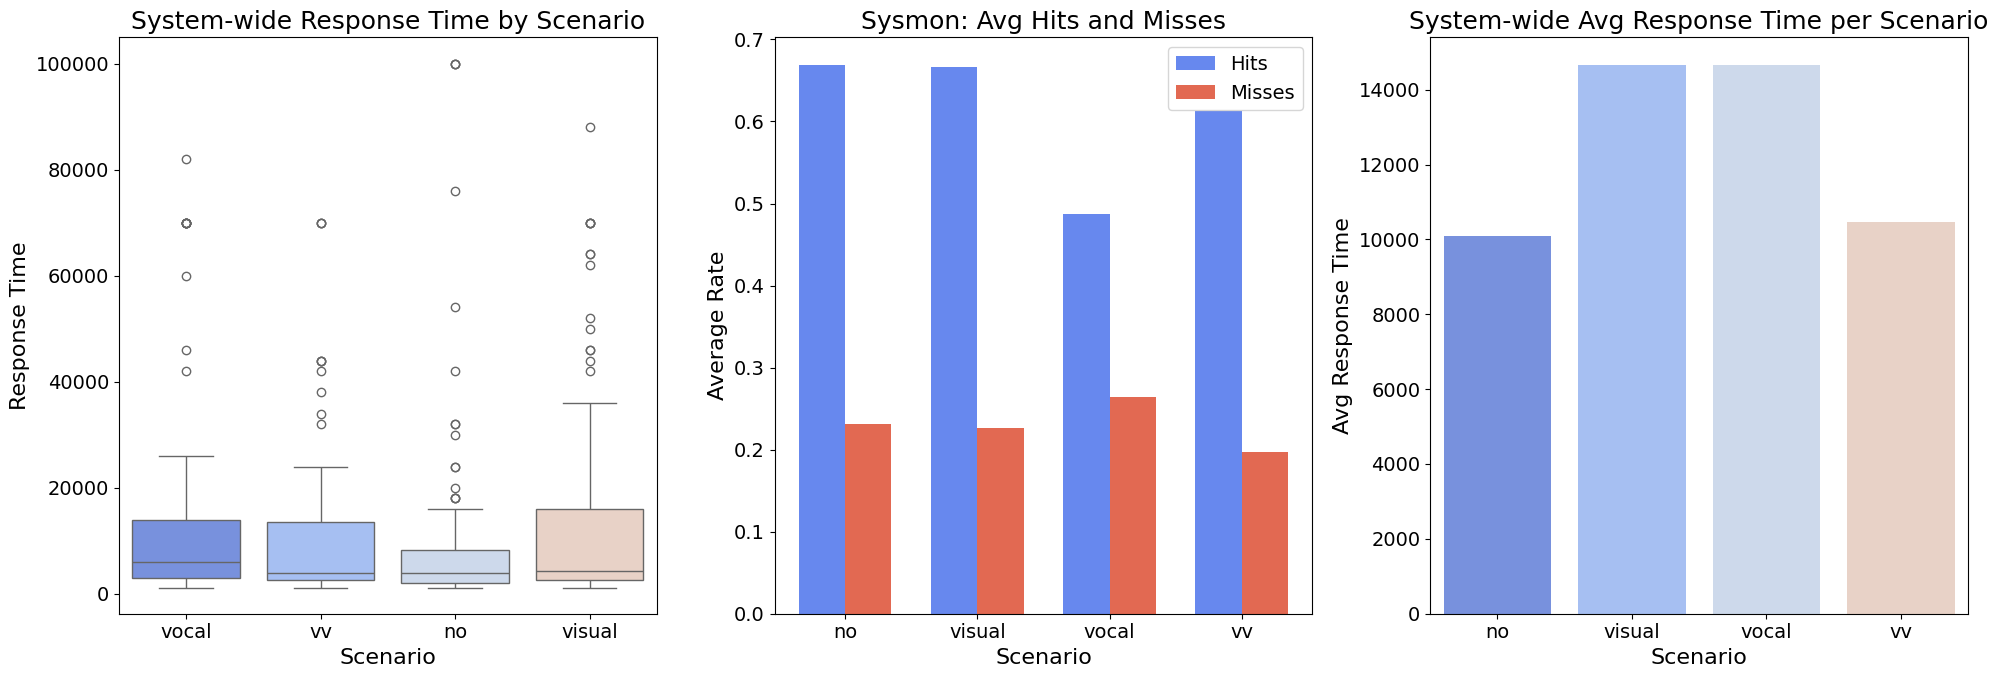

In [42]:
# --- Publication-ready figure with larger fonts: system-wide boxplot, sysmon avg hits/misses, system-wide avg response time ---
import matplotlib.pyplot as plt
import seaborn as sns

custom_palette = sns.color_palette('coolwarm')

plt.rcParams.update({'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14})

fig, axs = plt.subplots(1, 3, figsize=(20, 7))

# 1. System-wide response time boxplot by scenario
sns.boxplot(x=combined['scenario'], y=combined['response_time'], palette=custom_palette, ax=axs[0])
axs[0].set_title('System-wide Response Time by Scenario', fontsize=18)
axs[0].set_xlabel('Scenario', fontsize=16)
axs[0].set_ylabel('Response Time', fontsize=16)

# 2. Sysmon average hits and misses barplot
scenarios = agg['scenario']
bar_width = 0.35
index = range(len(scenarios))
axs[1].bar(index, agg['avg_hits'], bar_width, label='Hits', color=custom_palette[0])
axs[1].bar([i + bar_width for i in index], agg['avg_misses'], bar_width, label='Misses', color=custom_palette[-1])
axs[1].set_xlabel('Scenario', fontsize=16)
axs[1].set_ylabel('Average Rate', fontsize=16)
axs[1].set_title('Sysmon: Avg Hits and Misses', fontsize=18)
axs[1].set_xticks([i + bar_width / 2 for i in index])
axs[1].set_xticklabels(scenarios, fontsize=14)
axs[1].legend(fontsize=14)

# 3. System-wide average response time barplot
avg_system = combined.groupby('scenario')['response_time'].mean().reset_index()
sns.barplot(x='scenario', y='response_time', data=avg_system, palette=custom_palette, ax=axs[2])
axs[2].set_title('System-wide Avg Response Time per Scenario', fontsize=18)
axs[2].set_xlabel('Scenario', fontsize=16)
axs[2].set_ylabel('Avg Response Time', fontsize=16)
axs[2].set_xticklabels(avg_system['scenario'], fontsize=14)

plt.tight_layout()
plt.show()